<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-на-train-/-test-выборки" data-toc-modified-id="Разделение-на-train-/-test-выборки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разделение на train / test выборки</a></span></li><li><span><a href="#Мешок-слов" data-toc-modified-id="Мешок-слов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Мешок слов</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>TF-IDF</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**Цель**

Выбрать модель для распознования токсичных комментариев.

Подготовку данных буду делать с помощью библиотеки nltk

In [ ]:
#pip install nltk

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import re
from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Импортирую необходимые библиотеки и произвожу загрузки.

In [3]:
RANDOM_STATE = 42

Задаю константу RANDOM_STATE для контроля случайности.

In [4]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('...', index_col=0)

In [5]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df.shape

(159292, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Датасет имеет два столбца: text - текст комментария типа object, toxic - столбец разметки типа int64 (0 - комментарий нетоксичный, 1 - комментарий токсичный). Комментарии на английском языке. В датасете 159292 комментария. Пустых ячеек нет.

In [8]:
den_toxic = df['toxic'].value_counts(normalize=True)
den_toxic.index = ['нетоксичные', 'токсичные']
den_toxic

нетоксичные    0.898388
токсичные      0.101612
Name: toxic, dtype: float64

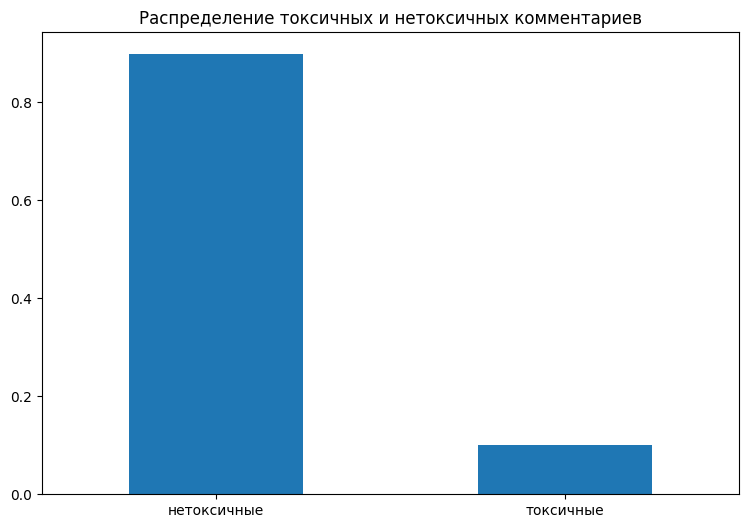

In [9]:
den_toxic.plot(kind='bar',
               title='Распределение токсичных и нетоксичных комментариев', 
               figsize=(9, 6), 
               rot=0);

Имеется дизбаланс классов. Отношение нетоксичных к токсичным 9:1.

In [10]:
def get_cleared_text(text):
    text = text.lower() #привожу текст к нижнему регистру
    text = re.sub(r'[^a-z0-9]', ' ', text) #заменяю все символы не относящиеся к английским буквам и цифрам на пробел
    text = ' '.join(text.split()) #удаляю лишние пробелы
    return text

get_cleared_text - функция возвращает текст в нижнем регистре очищенный от лишних символов.

In [12]:
df['text'] = df['text'].apply(get_cleared_text)
df

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0
...,...,...
159446,and for the second time of asking when your vi...,0
159447,you should be ashamed of yourself that is a ho...,0
159448,spitzer umm theres no actual article for prost...,0
159449,and it looks like it was actually you who put ...,0


Комментарии очищены от лишних символов.

In [13]:
for text in df[df['toxic'] == 1]['text'].head(10):
    print(text, end='\n\n')

cocksucker before you piss around on my work

hey what is it talk what is it an exclusive group of some wp talibans who are good at destroying self appointed purist who gang up any one who asks them questions abt their anti social and destructive non contribution at wp ask sityush to clean up his behavior than issue me nonsensical warnings

bye don t look come or think of comming back tosser

you are gay or antisemmitian archangel white tiger meow greetingshhh uh there are two ways why you do erased my comment about ww2 that holocaust was brutally slaying of jews and not gays gypsys slavs anyone 1 if you are anti semitian than shave your head bald and go to the skinhead meetings 2 if you doubt words of the bible that homosexuality is a deadly sin make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals 3 first and last warning you fucking gay i won t appreciate if any more nazi shwain would write in my page i don t wish to talk to you anymore beware of the

In [14]:
for text in df[df['toxic'] == 0]['text'].head(10):
    print(text, end='\n\n')

explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now 89 205 38 27

d aww he matches this background colour i m seemingly stuck with thanks talk 21 51 january 11 2016 utc

hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info

more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let 

Посмотрела на качество разметки по 10 комментариям, размеченным как токсичные и по 10 комментариям, размеченным как нетоксичные. Для этого набора разметка верна. 

In [15]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV} 
    return tag_dict.get(tag, wordnet.NOUN)

get_wordnet_pos - функция возвращает словарь, где возвращается значение часть речи (pos_tag)

In [17]:
def get_lemmatized_text(text):
    result = []
    for word in text.split():
        if word not in stopwords.words('english'):
            result.append(WordNetLemmatizer().lemmatize(word, get_wordnet_pos(word))) 
    return ' '.join(result)

In [22]:
tqdm.pandas()
df['text'] = df['text'].progress_apply(get_lemmatized_text)
df

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic
0,explanation edits make username hardcore metal...,0
1,aww match background colour seemingly stuck th...,0
2,hey man really try edit war guy constantly rem...,0
3,make real suggestion improvement wonder sectio...,0
4,sir hero chance remember page,0
...,...,...
159446,second time ask view completely contradicts co...,0
159447,ashamed horrible thing put talk page 128 61 19 93,0
159448,spitzer umm there actual article prostitution ...,0
159449,look like actually put speedy first version de...,0


get_lemmatized_text - функция возвращает текст с лемматизировнным набором слов и с удаленными стоп-словами.

In [23]:
sum(df['text'] == '')

25

In [24]:
df[df['text'] == '']

,text,toxic
2400,,0
9386,,0
12404,,0
23071,,0
26378,,0
31044,,0
31990,,0
38277,,0
58556,,0
64257,,0


25 комментариев преобразовались в пустые строки. Видимо, они содержали только стоп-слова и символы не относящиеся к буквам английского алфавита и цифрам.

Данные лемматизированны, стоп-слова удалены.

## Обучение

### Разделение на train / test выборки

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], 
                                                    df['toxic'], 
                                                    test_size=0.1, 
                                                    stratify=df['toxic'], 
                                                    random_state=RANDOM_STATE)

Разделяю данные на обучающую и тестовую выборки со стратификацией, чтобы сохранить соотношение классов в обеих выборках.

In [26]:
X_train

22605     please stop continue vandalize page saint vict...
150502    chanology nonviolence comment say one edits ch...
17008     change specie abbreviation template remove pip...
51716     red head boy blonde girl tease tease brunette ...
51973         britain need help stop islam britain vote bnp
                                ...                        
104782    identify give reason wikipedia source break ne...
94439     pretty disingenuous erik clever enough know li...
107783    attend wellesley washington program urge profe...
94548     abraham de vries minister hi jane thanks lot f...
85871     question seem ip 98 179 149 193 cause trouble ...
Name: text, Length: 143362, dtype: object

In [27]:
X_test

151009     ok seem pretty clear editor responsible amalthea
30615     proposal standard infobox history country temp...
35343     hi pompous as know think kind poker authority ...
156814    attack guy censor opinion agree respond proof ...
97214     include peter emerich peter hermit emerich res...
                                ...                        
108178    sorry want report user http en wikipedia org w...
135579    oh good one elonka glad abuse administrative p...
59188                             9 february 2008 utc 00 17
36250     low attention peer review old peer review imag...
30016     consider communication extremely important not...
Name: text, Length: 15930, dtype: object

In [28]:
den_toxic = pd.DataFrame({'обучение': y_train.value_counts(), 'тест': y_test.value_counts()})
den_toxic.index = ['нетоксичные', 'токсичные']
den_toxic

,обучение,тест
нетоксичные,128795,14311
токсичные,14567,1619


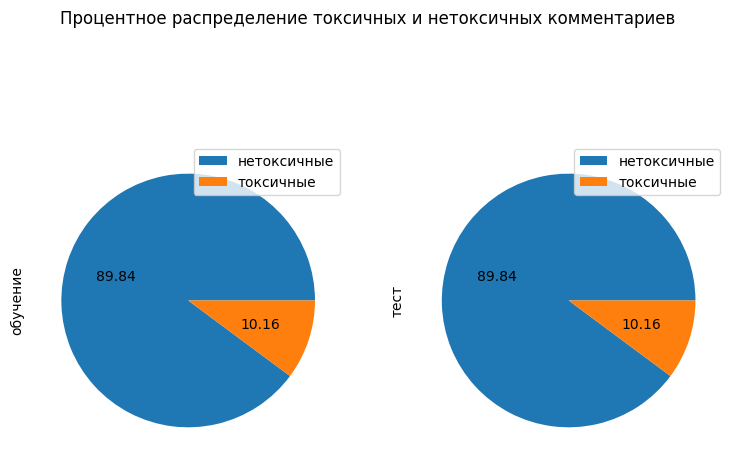

In [29]:
den_toxic.plot(kind='pie', 
               subplots=True, 
               title='Процентное распределение токсичных и нетоксичных комментариев', 
               figsize=(9, 6), 
               labeldistance=None, 
               autopct='%.2f');

Соотношение токсичных и нетоксичных комментариев и в обучающей и в тестовой выборках около 1 к 9.

### Мешок слов

#### LogisticRegression

In [30]:
pipe_bag_lr = Pipeline([('count_vect', CountVectorizer(ngram_range=(1, 2))), ('log_reg', LogisticRegression())])

Создала мешок слов, используя сами слова из комментариев обучающей выборки и биграммы, составленные по комментариям обучающей выборки. В качестве модели выбрала логистическую регрессию. 

In [31]:
%%time
param_grid = {'log_reg__C': [0.01, 0.1, 1, 10, 100],
              'log_reg__class_weight': ['balanced']}
gs_bag_lr = GridSearchCV(estimator=pipe_bag_lr, 
                         param_grid=param_grid, 
                         scoring='f1',
                         cv=5,
                         n_jobs=-1)
gs_bag_lr.fit(X_train, y_train)

CPU times: total: 40.4 s
Wall time: 7min 50s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('count_vect',
                                        CountVectorizer(ngram_range=(1, 2))),
                                       ('log_reg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'log_reg__C': [0.01, 0.1, 1, 10, 100],
                         'log_reg__class_weight': ['balanced']},
             scoring='f1')

In [32]:
bag_lr_results = pd.DataFrame(gs_bag_lr.cv_results_)[['rank_test_score', 'params', 'mean_test_score']]
bag_lr_results['C'] = bag_lr_results['params'].apply(lambda x: x['log_reg__C'])
bag_lr_results[['rank_test_score', 'C', 'mean_test_score']].sort_values(by='rank_test_score')

,rank_test_score,C,mean_test_score
2,1,1.00,0.789429
3,2,10.00,0.787467
4,3,100.00,0.780110
1,4,0.10,0.775512
0,5,0.01,0.722317


Обучила модель по решетке на кроссвалидации, подбирала только гиперпараметр С, чтобы сократить время обучения. Значением гиперпараметра class_weight выбрала balanced, потому что в данных имеется дизбаланс классов, а задачей стоит, как и максимально распознать все токсичные комментарии, так и минимальное количество нетоксичных определить как токсичные. Лучшую модель в решетке отбираю по метрике f1 согласно условию задачи. Лучшие результаты на кроссвалидации показала модель с C=1.

#### RandomForestClassifier

In [33]:
pipe_bag_rf = Pipeline([('count_vect', CountVectorizer(ngram_range=(1, 2))), ('rand_for', RandomForestClassifier())])

In [34]:
%%time
param_grid = {'rand_for__max_depth': [10, 50, 100, 200, 500],
              'rand_for__n_estimators': [20],
              'rand_for__random_state': [RANDOM_STATE], 
              'rand_for__n_jobs': [-1], 
              'rand_for__class_weight': ['balanced']}
gs_bag_rf = GridSearchCV(estimator=pipe_bag_rf, 
                         param_grid=param_grid, 
                         scoring='f1',
                         cv=5,
                         n_jobs=-1)
gs_bag_rf.fit(X_train, y_train)

CPU times: total: 27min 21s
Wall time: 21min 43s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('count_vect',
                                        CountVectorizer(ngram_range=(1, 2))),
                                       ('rand_for', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rand_for__class_weight': ['balanced'],
                         'rand_for__max_depth': [10, 50, 100, 200, 500],
                         'rand_for__n_estimators': [20],
                         'rand_for__n_jobs': [-1],
                         'rand_for__random_state': [42]},
             scoring='f1')

In [35]:
bag_rf_results = pd.DataFrame(gs_bag_rf.cv_results_)[['rank_test_score', 'params', 'mean_test_score']]
bag_rf_results['max_depth'] = bag_rf_results['params'].apply(lambda x: x['rand_for__max_depth'])
bag_rf_results[['rank_test_score', 'max_depth', 'mean_test_score']].sort_values(by='rank_test_score')

,rank_test_score,max_depth,mean_test_score
4,1,500,0.549375
3,2,200,0.487300
2,3,100,0.430733
1,4,50,0.367268
0,5,10,0.281725


Для модели случайного леса подбирала только гиперпараметр max_depth, средняя оценка f1 для глубины 500 доходит лишь до 0.55, что гораздо меньше, чем у логистической регрессии.

#### LGBMClassifier

In [36]:
pipe_bag_lgbm = Pipeline([('count_vect', CountVectorizer(dtype=np.float32, ngram_range=(1, 2))), ('lgbm', LGBMClassifier())])

In [37]:
%%time
param_grid = {'lgbm__n_estimators': [10, 50, 100, 200], 
              'lgbm__max_depth': range(4, 21, 4), 
              'lgbm__random_state': [RANDOM_STATE],
              'lgbm__class_weight': ['balanced'], 
              'lgbm__objective': ['binary'],
              'lgbm__n_jobs': [-1]}
gs_bag_lgbm = GridSearchCV(estimator=pipe_bag_lgbm, 
                           param_grid=param_grid, 
                           scoring='f1',
                           cv=5,
                           n_jobs=-1)
gs_bag_lgbm.fit(X_train, y_train)

CPU times: total: 4min 39s
Wall time: 26min 6s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('count_vect',
                                        CountVectorizer(dtype=<class 'numpy.float32'>,
                                                        ngram_range=(1, 2))),
                                       ('lgbm', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'lgbm__class_weight': ['balanced'],
                         'lgbm__max_depth': range(4, 21, 4),
                         'lgbm__n_estimators': [10, 50, 100, 200],
                         'lgbm__n_jobs': [-1], 'lgbm__objective': ['binary'],
                         'lgbm__random_state': [42]},
             scoring='f1')

In [38]:
bag_lgbm_results = pd.DataFrame(gs_bag_lgbm.cv_results_)[['rank_test_score', 'params', 'mean_test_score']]
bag_lgbm_results['max_depth'] = bag_lgbm_results['params'].apply(lambda x: x['lgbm__max_depth'])
bag_lgbm_results['n_estimators'] = bag_lgbm_results['params'].apply(lambda x: x['lgbm__n_estimators'])
bag_lgbm_results[['rank_test_score', 'max_depth', 'n_estimators', 'mean_test_score']].sort_values(by='rank_test_score').head(10)

,rank_test_score,max_depth,n_estimators,mean_test_score
19,1,20,200,0.756335
15,2,16,200,0.755071
11,3,12,200,0.754198
7,4,8,200,0.745278
18,5,20,100,0.741631
14,6,16,100,0.740639
10,7,12,100,0.735417
6,8,8,100,0.727470
3,9,4,200,0.726787
17,10,20,50,0.724127


Для модели градиентного бустинга подбирала только гиперпараметры n_estimators, max_depth, лучшие результаты f1 были получены для n_estimators = 200, max_depth не так сильно влияет на результат (max_depth брала небольшие, чтобы не переобучиться). Возможно, если еще увеличить n_estimators, то значение f1 вырастет до показателей логистической регрессии, но при этом очень возрастет время обучения.

#### Выводы

Были исследованы модели логистической регрессии, случайного леса, градиентного бустинга (LGBM). Лучшая оценка f1 на кросс-валидации с использованием мешка слов получена для логистической регрессии с параметрами по умолчанию.

### TF-IDF

#### LogisticRegression

In [39]:
pipe_tfidf_lr = Pipeline([('tfidf_vect', TfidfVectorizer(ngram_range=(1, 2))), ('log_reg', LogisticRegression())])

Создала матрицу cо значениями TF-IDF, используя сами слова из комментариев обучающей выборки и биграммы, составленные по комментариям обучающей выборки. В качестве модели выбрала логистическую регрессию.

In [40]:
%%time
param_grid = {'log_reg__C': [0.1, 1, 10, 100, 200, 500],
              'log_reg__class_weight': ['balanced']}
gs_tfidf_lr = GridSearchCV(estimator=pipe_tfidf_lr,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           n_jobs=-1)
gs_tfidf_lr.fit(X_train, y_train)

CPU times: total: 1min 14s
Wall time: 9min 31s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf_vect',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('log_reg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'log_reg__C': [0.1, 1, 10, 100, 200, 500],
                         'log_reg__class_weight': ['balanced']},
             scoring='f1')

In [41]:
tfidf_lr_results = pd.DataFrame(gs_tfidf_lr.cv_results_)[['rank_test_score', 'params', 'mean_test_score']]
tfidf_lr_results['C'] = tfidf_lr_results['params'].apply(lambda x: x['log_reg__C'])
tfidf_lr_results[['rank_test_score', 'C', 'mean_test_score']].sort_values(by='rank_test_score')

,rank_test_score,C,mean_test_score
3,1,100.0,0.791901
4,2,200.0,0.791637
5,3,500.0,0.789904
2,4,10.0,0.785897
1,5,1.0,0.750995
0,6,0.1,0.698119


Лучшее среднее значение f1 достигнуто для C = 200.

#### LGBMClassifier

In [42]:
pipe_tfidf_lgbm = Pipeline([('tfidf_vect', TfidfVectorizer(dtype=np.float32, ngram_range=(1, 2))), ('lgbm', LGBMClassifier())])

In [43]:
%%time
param_grid = {'lgbm__n_estimators': [10, 50, 100, 200], 
              'lgbm__max_depth': range(4, 21, 4), 
              'lgbm__random_state': [RANDOM_STATE],
              'lgbm__class_weight': ['balanced'], 
              'lgbm__objective': ['binary'],
              'lgbm__n_jobs': [-1]}
gs_tfidf_lgbm = GridSearchCV(estimator=pipe_tfidf_lgbm, 
                             param_grid=param_grid, 
                             scoring='f1',
                             cv=5,
                             n_jobs=-1)
gs_tfidf_lgbm.fit(X_train, y_train)

CPU times: total: 9min 9s
Wall time: 37min 8s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf_vect',
                                        TfidfVectorizer(dtype=<class 'numpy.float32'>,
                                                        ngram_range=(1, 2))),
                                       ('lgbm', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'lgbm__class_weight': ['balanced'],
                         'lgbm__max_depth': range(4, 21, 4),
                         'lgbm__n_estimators': [10, 50, 100, 200],
                         'lgbm__n_jobs': [-1], 'lgbm__objective': ['binary'],
                         'lgbm__random_state': [42]},
             scoring='f1')

In [44]:
tfidf_lgbm_results = pd.DataFrame(gs_tfidf_lgbm.cv_results_)[['rank_test_score', 'params', 'mean_test_score']]
tfidf_lgbm_results['max_depth'] = tfidf_lgbm_results['params'].apply(lambda x: x['lgbm__max_depth'])
tfidf_lgbm_results['n_estimators'] = tfidf_lgbm_results['params'].apply(lambda x: x['lgbm__n_estimators'])
tfidf_lgbm_results[['rank_test_score', 'max_depth', 'n_estimators', 'mean_test_score']].sort_values(by='rank_test_score').head(10)

,rank_test_score,max_depth,n_estimators,mean_test_score
19,1,20,200,0.750972
15,2,16,200,0.750581
11,3,12,200,0.746883
7,4,8,200,0.739603
14,5,16,100,0.734321
18,6,20,100,0.734199
10,7,12,100,0.731337
3,8,4,200,0.724207
6,9,8,100,0.723014
17,10,20,50,0.717541


Градиентный бустинг показывает результаты хуже, чем логистическая регрессия.

#### Выводы

Были исследованы модели логистической регрессии и градиентного бустинга (LGBM). Лучшая оценка f1 на кросс-валидации с использованием матрицы cо значениями TF-IDF получена для логистической регрессии с C = 200 и остальными параметрами по умолчанию.

## Выводы

Лучшие результаты f1 на кросс-валидации показала модель логистической регрессии с C = 200 и остальными параметрами по умолчанию с кодировкой текста с помощью TF-IDF. Также логистическая регрессия обучается быстрее других моделей использованных в исследовании.

In [45]:
best_model = Pipeline([('tfidf_vect', TfidfVectorizer(ngram_range=(1, 2))), ('log_reg', LogisticRegression(C=200))])

In [46]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf_vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('log_reg', LogisticRegression(C=200))])

In [48]:
def get_metrics(estimator, X, y): 
    print('presicion: ', round(precision_score(y, estimator.predict(X)), 4)) 
    print('recall: ', round(recall_score(y, estimator.predict(X)), 4)) 
    print('f1: ', round(f1_score(y, estimator.predict(X)), 4))

In [49]:
print('Метрики для лучшей модели на обучающей выборке')
get_metrics(best_model, X_train, y_train)

Метрики для лучшей модели на обучающей выборке
presicion:  0.9978
recall:  0.9974
f1:  0.9976


In [50]:
print('Метрики для лучшей модели на тестовой выборке')
get_metrics(best_model, X_test, y_test)

Метрики для лучшей модели на тестовой выборке
presicion:  0.8621
recall:  0.761
f1:  0.8084


Метрика f1 на тестовой выборке 0.8084.

In [51]:
coef = best_model.steps[1][1].coef_[0]
vocabulary = best_model.steps[0][1].vocabulary_ 
importance = []
words = []
for word in vocabulary:
    words.append(word)
    importance.append(abs(coef[vocabulary[word]]))
feature_importance = pd.Series(data=importance, index=words)

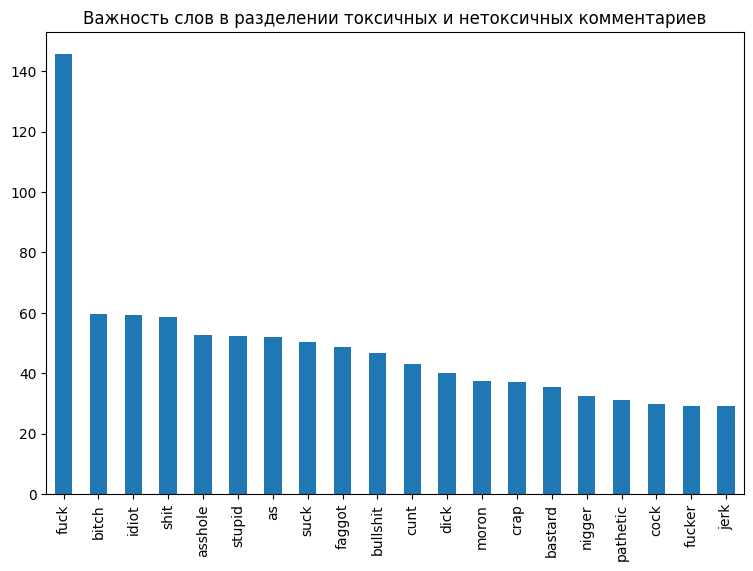

In [52]:
feature_importance.sort_values(ascending=False).head(20).\
plot(kind='bar',
      title='Важность слов в разделении токсичных и нетоксичных комментариев',
      figsize=(9, 6));

Сюдя по графику решающее значение для модели в определении категории комментария представляет наличие или отсутствие в комментарии ненормативной лексики.

Общий вывод:

В моем распоряжении был набор данных с комментариями пользователей и разметкой о токсичности этих комментариев. Передо мной была поставлена задача - обучить модель машиннного обучения классифицировать комментарии на токсичные и нетоксичные.

Датасет имел два столбца: text - текст комментария типа object, toxic - столбец разметки типа int64 (0 - комментарий нетоксичный, 1 - комментарий токсичный).

Комментарии на английском языке. В датасете 159292 комментария. Пустых ячеек не было. Данные в датасете не сбалансированы, отношение нетоксичных к токсичным 9:1. 

Комментарии были очищены от лишних символов (оставлены только буквы английского алфавита и цифры) и переведены к нижнему регистру. Затем данные были лемматизированны, из них удалены стоп-слова.

Данные были разделены на обучающую и тестовую выборки со стратификацией, чтобы сохранить соотношение классов в обеих выборках.

Было исследованно два способа предобработки текста (bag of words, TF-IDF), три типа моделей (логистическая регрессия, случайный лес, градиентный бустинг). Лучшие результаты показали модели логистической регрессии, к тому же они быстрее обучаются, чем остальные исследованные модели. Лучший результат на кросс-валидации был получен для сочетания TF-IDF (слова, биграммы) + LogisticRegression(С=200), эта модель была обучена всем обучающем датасете, f1 на тесте составила 0.791.

Были исследованны "решающие" слова для модели, ими оказались ненормативные слова.